### import libraries

In [65]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import clean_reviews as clean
import sklearn
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
tqdm.pandas()

#### check version of nltk and sklearn

In [63]:
#scikit version must be at least 1.0 
# !pip install scikit-learn==1.0.2
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The nltk version is 3.6.5.
The scikit-learn version is 0.24.2.


## Load dataset and explore 

In [66]:
df = pd.read_csv('./amz_tshirt_reviews.csv')

In [32]:
df.shape

(40521, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  40521 non-null  object 
 1   attr          0 non-null      float64
 2   scores        40441 non-null  object 
 3   review_title  40441 non-null  object 
 4   reviews       40521 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [5]:
df.sample(5)

,product_name,attr,scores,review_title,reviews
16887,Hanes Men’s Short Sleeve Graphic T-shirt Colle...,NaN,5.0 out of 5 stars,\nGood quality T-Shirt for a good price\n,"<span class=""a-size-base review-text review-te..."
38288,"Comfort Colors Men's Adult Short Sleeve Tee, S...",NaN,5.0 out of 5 stars,\nSilky soft but not clingy or thin/see through\n,"<span class=""a-size-base review-text review-te..."
38717,"Comfort Colors Men's Adult Short Sleeve Tee, S...",NaN,5.0 out of 5 stars,\nLove comfort colors!\n,"<span class=""a-size-base review-text review-te..."
5748,Carhartt Mens Loose Fit Heavyweight Short-slee...,NaN,4.0 out of 5 stars,"\nNice shirts, hate the tag!\n","<span class=""a-size-base review-text review-te..."
35906,Amazon Essentials Men's 2-Pack Slim-fit Short-...,NaN,2.0 out of 5 stars,"\nNice shirt, but too short.\n","<span class=""a-size-base review-text review-te..."


In [33]:
#increase the column width to be able to view long reviews 
pd.set_option('max_colwidth', 500)
df['reviews'].sample(1)

5731    <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  I am 6'0 and 195 lbs. No gut, and pretty athletic. 40-42 chest, 33 inch waist, and a SMALL fit perfect. You read right. A SMALL. length is below the crotch, and sleeves are wide, but torso is perfect. Best t-shirts ever, but beware of size. I have it in 4 colors, a made in different countries, and despite a 0.5 inch discrepancy among them, small fits me the best. Ironically, the medium in their Sier...
Name: reviews, dtype: object

#### check null values

In [34]:
df.isnull().sum().sort_values(ascending = False)

attr            40521
scores             80
review_title       80
product_name        0
reviews             0
dtype: int64

<AxesSubplot:>

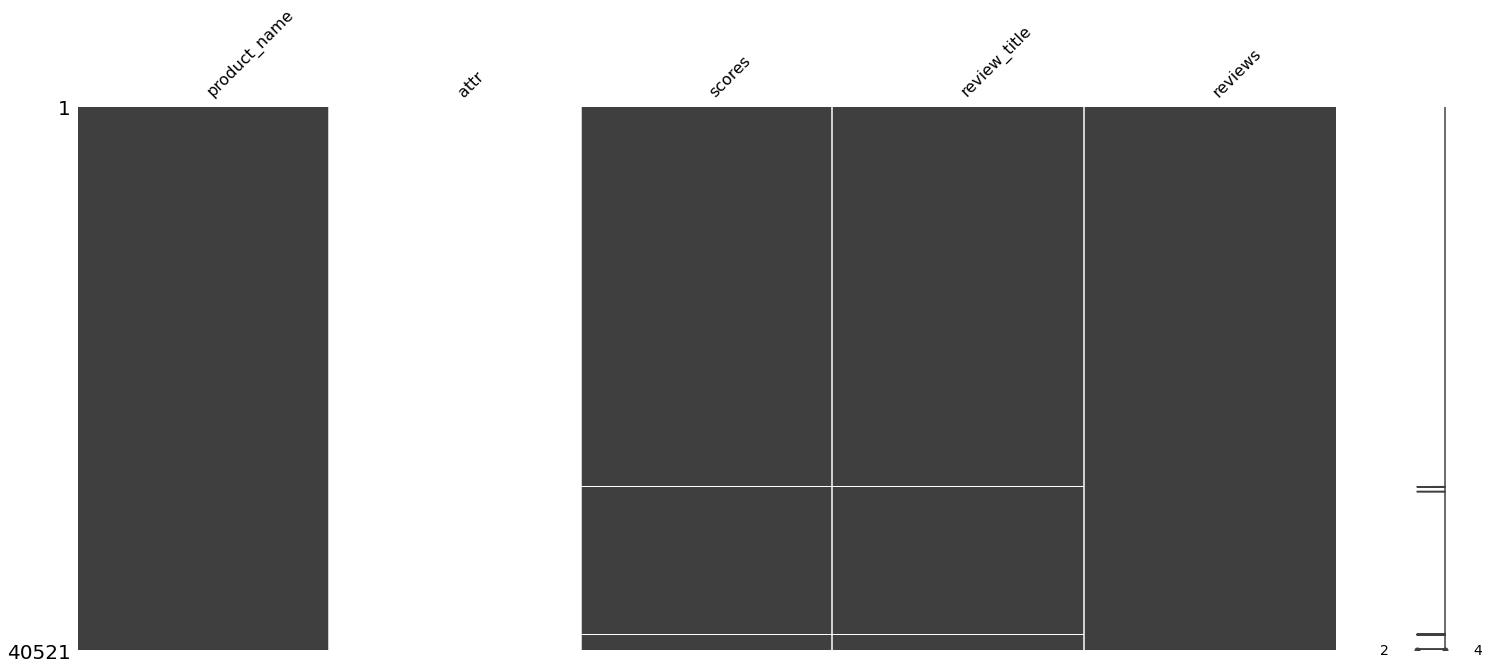

In [8]:
#plot missing values 
msno.matrix(df)

 when I webscrapped the data, I had a bug that caused the 'attr' column to be null, I need to re-run the webscrapping ipynb file and get the complete dataset. I tried doing it multiple times but I keep getting blocked! :laughing:

In [67]:
#drop attr column
df.drop('attr', axis = 1, inplace = True)

In [68]:
#drop rows with all null values 
df = df.dropna(axis = 0, subset= ['reviews', 'review_title', 'scores'])

In [69]:
#check for duplicates 
duplicate = df[df.duplicated()]
duplicate.shape


(20415, 4)

 aparently, half the data is duplicated. Must be a bug in the webscrapping script that stored each row twice. We will drop duplicates for now
 

In [70]:
#drop al duplicates then reset_index
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index', inplace= True)


## Extract review score as int
convert the rating string to integer 

In [39]:
df['scores'].sample(3)

6016     4.0 out of 5 stars
16538    4.0 out of 5 stars
2522     5.0 out of 5 stars
Name: scores, dtype: object

In [71]:
#for null ratings, I will give a rating of 9 so I know later that they were unknown ratings
df.scores.fillna('9', inplace= True)
df.scores = df.scores.str.slice(start = 0, stop =1)

## Use clean.py to clean the data
clean 'reviews' & 'review_title' column from <>, \n, punctuations. and replace words like "I'll" to "I will" and "arn't" to "are not"


In [41]:

df.reviews = df.reviews.progress_apply(clean.clean)
df.review_title = df.review_title.progress_apply(clean.clean)

100%|██████████| 20026/20026 [00:11<00:00, 1757.28it/s]


### Change datatypes

In [72]:
# using dictionary to convert specific columns
convert_dict = {'product_name': str,
				'review_title' : str,
                'reviews' : str,
                'scores' : int
               }
df = df.astype(convert_dict)

### Fill null 'review_title' based on score or review 

In [43]:
#this function checks if the title is empty or == 'nan', then -> it will check the score and convert it into word based on the rating_dict. 
# If the score is 9 (which means null), it will take the first sent in the review  
# 'nan' means null, and it results from the clean method


def create_title(title, score, review):

    rating_dict = {5:'perfect', 4: 'good', 3: 'ok', 2: 'bad', 1: 'terrible'}
    x = ''
    if (title == 'nan') or (title.strip() == ''):

        if (score < 9):
            x = rating_dict[int(score)]
        else:

            if bool(review.strip().split('.')[0]) :
                x = review.split('.')[0]
                x = " ".join(x.strip().split(" ")[0:10])
            else:

                x = " ".join(review.strip().split(" ")[0:10])
        return x
    else:
        return title
    


In [44]:
#apply create_title
df['review_title'] = df.apply(lambda x: create_title(x['review_title'], x['scores'], x['reviews']), axis = 1)

# How many products does this dataset have? 

In [45]:
df.product_name.nunique()

46

# What is the distribution of scores 

Text(0.5, 1.0, 'Count of Reviews per Rating Score ')

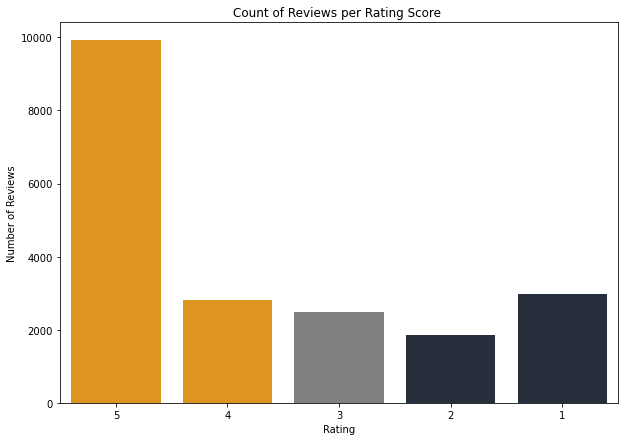

In [75]:
clrs = ['#FF9900', '#FF9900', 'grey', '#232F3E', '#232F3E']
sns.countplot( data = df, x = 'scores', order = [5, 4, 3, 2, 1], palette=clrs)
# sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.gcf().set_size_inches(10, 7)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title("Count of Reviews per Rating Score ")



## most of the reviews are 4 and 5 stars.
#### Since we only have few for 1 and 2 stars, I will consider 3 stars as a negative review. I will create a new boolean column called 'like' which answers the question: 'did the customer like the product or not?'
- 'yes': for 4 & 5 stars ratings
- 'no' :  for 3, 2, and 1 stars 

In [76]:
#create 'like' column
df.scores = df.scores.astype(int)
def like(x):
    x = int(x)
    if x > 8:
        return None
    else:
        return x > 3

df['like'] = df.scores.apply(like)
# df['like'] = df['like'].astype(bool)

Text(0.5, 0, 'Is it a positive review?')

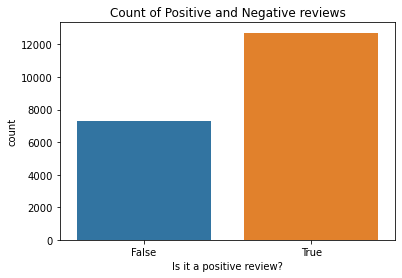

In [78]:
sns.countplot(data=df, x = 'like')
plt.title("Count of Positive and Negative reviews")
plt.xlabel('Is it a positive review?')


### Extract brand from 'product_name'
##### it seems that the first word of the product_name is often the brand name, so we will create a column for that 

In [49]:
def get_brand(text):
    return text.split(" ")[0]

df['brand'] = df.product_name.progress_apply(get_brand)

100%|██████████| 20026/20026 [00:00<00:00, 53979.82it/s]


### Extract gneder from 'product_name'

In [50]:
def get_gender(text):
    if 'women' in text.lower():
        return 'women'
    elif 'men' in text.lower():
        return 'men'
    else:
        return 'not_specified'

df['gender'] = df['product_name'].progress_apply(get_gender)

100%|██████████| 20026/20026 [00:00<00:00, 36468.76it/s]


<AxesSubplot:xlabel='scores', ylabel='count'>

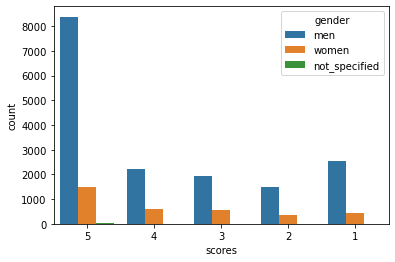

In [25]:
sns.countplot(data = df, x = 'scores', hue = 'gender', order = [5, 4, 3, 2, 1])

Data is not balanced between male and female products, so I assume that most of the reviews are written by male users. 

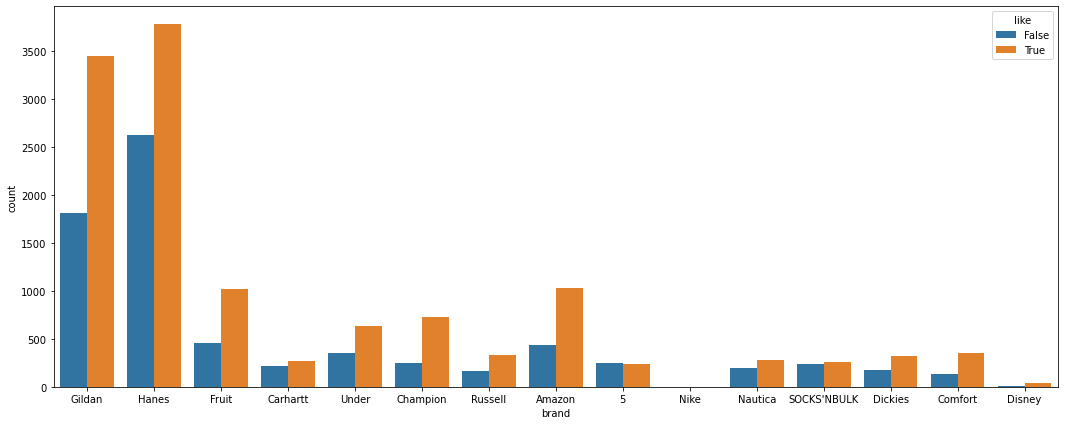

In [30]:
brands = sns.countplot(data = df, x = 'brand', hue = 'like')
plt.gcf().set_size_inches(18, 7)


Gildan and Hanes have the most review count, more data means better key insights :) 

## how many words per review
Do negative reviews tend to be longer than positive reviews? 

In [15]:
df['rev_len'] = df['reviews'].str.split().apply(len)


(0.0, 250.0)

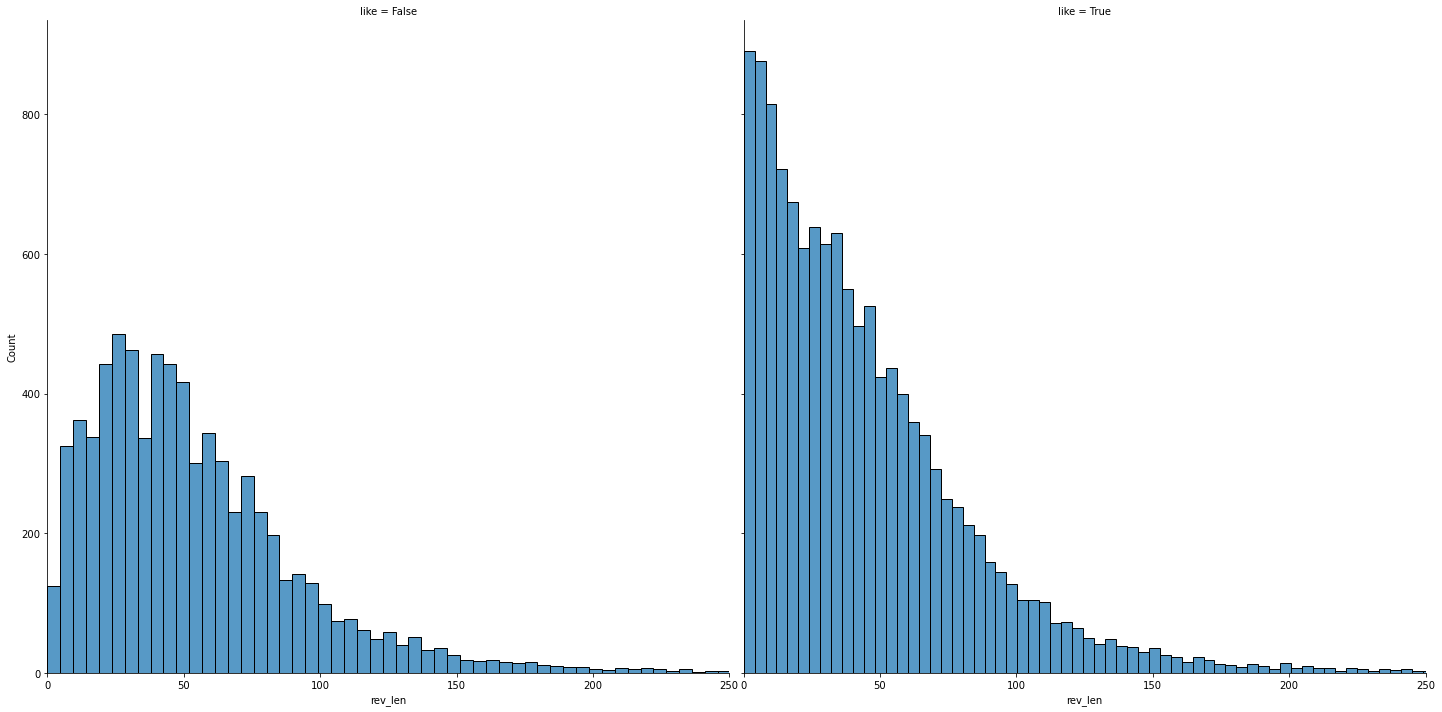

In [32]:
g = sns.FacetGrid(df, col ='like', height=10)
g.map(sns.histplot,'rev_len', linewidth = 1)
plt.xlim(0, 250)


I need to use log to be able to compare the mean length between positive and negative reviews 

In [22]:
# !pip install nlppreprocess

In [23]:
# I wanted to split the reviews into sentences but I realized I can do that with nltk
# df['reviews_splitted'] = df.reviews.apply(lambda x: re.split('[,.]', str(x)))

### Lemmatization


In [51]:
wnl = WordNetLemmatizer()
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lem_text(text):
    return [wnl.lemmatize(w) for w in word_tokenizer.tokenize(text)]

df['lemmatized_title'] = df['review_title'].progress_apply(lem_text)
df['lemmatized_review'] = df['reviews'].progress_apply(lem_text)



100%|██████████| 20026/20026 [00:32<00:00, 610.22it/s] 


### stopwords


In [52]:
all_stopwords = stopwords.words('english')

#there are important words in reviews that I don't want to remove, such as "size up" and "size down"
do_not_remove = ['not', 'no', 'up', 'down', 'above', 'below', 'off', 'again', 'too', 'y', 's', 't', 'o', 'd', 'm']
for word in all_stopwords:
    if (word in do_not_remove):
        all_stopwords.remove(word)

def remove_stopwords(text):
    return [word for word in text if word not in all_stopwords]





In [53]:
df['lemmatized_review'] = df.lemmatized_review.progress_apply(remove_stopwords)
df['lemmatized_title'] = df.lemmatized_title.progress_apply(remove_stopwords)

100%|██████████| 20026/20026 [00:20<00:00, 956.97it/s]  


In [60]:
df['lemmatized_review'] = df['lemmatized_review'].str.join(" ")
df['lemmatized_title'] = df['lemmatized_title'].str.join(" ")
#remove whitespace
df['lemmatized_review'] = df['lemmatized_review'].str.strip()
df['lemmatized_title'] = df['lemmatized_title'].str.strip()

In [62]:
from nltk import ngrams
from collections import Counter
 

In [64]:
pos_ngrams = [x for x in df['lemmatized_title'] for x in ngrams(x.split(), n = 3)]
c = Counter(pos_ngrams)
top_positive = c.most_common(10)

In [48]:
df['lemmatized_review'].sample(3)

16575                                                                                                                                                                                                                                                                                                                                              yes need thankful fol class self plea fol please not raise price like everyone else got remember already best way many year thank making best quality garment men woman
2952     i’m ’” lb nonathletic build minor beer belly everything purchase wa convenient starter value shirt stood you’re getting six cotton vneck shirt although fit bag slightly loose long i’m sure time wash it’ll shrink little quality reflects price term cut softness shirt higher end shirt usually soft buttery start shirt aren’t soft it’s average shirt see no negative speed promptness order wa exceptional ordered shirt wednesday delivered next day thursday pm shipping wa free rate i’m sa

## Stemmer

In [20]:
ps = PorterStemmer()

def stemm(text):
    text = text.split()
    text = [ps.stem(word) for word in text if not word in set(all_stopwords)]
    text = ' '.join(text)
    return text

In [21]:
df['stemmed_title'] = df['review_title'].progress_apply(stemm)
df['stemmed_review'] = df['reviews'].progress_apply(stemm)

100%|██████████| 20026/20026 [00:58<00:00, 344.17it/s] 


## CountVectorizer

Eventhough I vectorized the reviews later in the modeling section, I wanted to explore the reviews here to see most common words 

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

all_titles = df['review_title'].to_list()
cv = CountVectorizer(stop_words= all_stopwords)
df_cv = cv.fit_transform(all_titles)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names()   # name the columns
                        )

df_dtm.index = df.index


In [39]:
df_dtm.sum().sort_values(ascending = False).head(10)


great      2726
shirt      2548
not        2037
good       2004
shirts     1846
quality    1545
fit        1358
nice       1118
size        880
small       817
dtype: int64

In [40]:
all_titles = df['reviews'].to_list()
cv = CountVectorizer(stop_words= all_stopwords, max_df=2000)
df_cv = cv.fit_transform(all_titles)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names()   # name the columns
                        )

df_dtm.index = df.index

In [41]:
df_dtm.sum().sort_values(ascending = False).head(10)


cotton     2710
long       2277
little     2239
color      2125
fits       2099
perfect    2071
no         1945
colors     1938
get        1929
fabric     1889
dtype: int64

## not good enough!
this shows top used words, but it does not carry any info about the context in which the word is used

## WordCloud
I want to plot the most common words. but first, I want to remove words that do not carry a lot of information such as [shirt, fit, perfect, bed]
I want to create 2 wordclouds for positive and negative reviews

In [22]:
#add words to stopwords list 
new_stopwords = ['shirt', 'fit', 'not', 'good', 'perfect', 'great', 
'nice', 'love', 'like', 'wa', 'also', 'bought', 'would', 'one', 
'well', 'get', 'really', 'color', 'even', 'ordered', 'husband', 'buy', 'quality']
new_stopwords.extend(all_stopwords)

In [23]:
wc = WordCloud(stopwords=new_stopwords, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

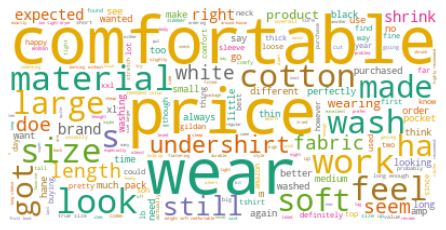

In [44]:
# create 2 wordclouds: positive and negative 

pos_rev = ' '.join([Text for Text in df[df['like'] == True]['lemmatized_review']])
pos_cloud = wc.generate(pos_rev)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.show()

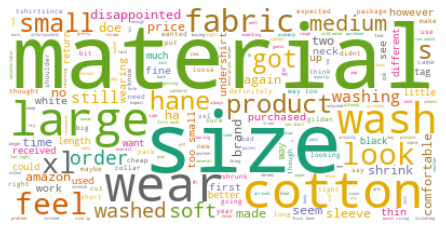

In [45]:
neg_rev = ' '.join([Text for Text in df[df['like'] == False]['lemmatized_review']])
neg_cloud = wc.generate(neg_rev)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.show()

### Save the cleaned data to a new csv file to be used in other notebooks
before I do that, I want to minimize review_title and review columns into one, so I will consider each entry in these 2 columns as a unique review, and I will concatenate them into one dataframe 

In [24]:
titles = df[['product_name', 'scores', 'brand', 'gender', 'like', 'review_title','lemmatized_title', 'stemmed_title']].copy()
titles.columns = ['product_name', 'scores', 'brand', 'gender', 'rating', 'review','lemm', 'stemmed']
titles.reset_index(drop = True, inplace=True)



In [120]:
titles.columns

Index(['product_name', 'scores', 'brand', 'gender', 'rating', 'review', 'lemm',
       'stemmed'],
      dtype='object')

In [25]:
reviews = df[['product_name', 'scores', 'brand', 'gender', 'like', 'reviews','lemmatized_review', 'stemmed_review']].copy()
reviews.columns = ['product_name', 'scores', 'brand', 'gender', 'rating', 'review','lemm', 'stemmed']
reviews.reset_index(drop = True, inplace=True)

In [122]:
reviews.columns

Index(['product_name', 'scores', 'brand', 'gender', 'rating', 'review', 'lemm',
       'stemmed'],
      dtype='object')

In [26]:
new_df = pd.concat([reviews, titles], ignore_index = True, axis=0)


In [124]:
new_df.columns

Index(['product_name', 'scores', 'brand', 'gender', 'rating', 'review', 'lemm',
       'stemmed'],
      dtype='object')

In [125]:
new_df.shape

(40052, 8)

#### create a column that removes all_stopwords from original review, we will test it when we do machine learning

In [27]:
new_df['stopped'] = new_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

In [28]:
new_df.sample(5)

,product_name,scores,brand,gender,rating,review,lemm,stemmed,stopped
37591,Amazon Essentials Men's 2-Pack Slim-fit Short-...,4,Amazon,men,True,mostly positive review,mostly positive review,mostli posit review,mostly positive review
22326,Fruit of the Loom Men's Stay Tucked Crew T-Shirt,1,Fruit,men,False,poor quality,poor quality,poor qualiti,poor quality
1889,"Gildan Men's Ultra Cotton Long Sleeve T-Shirt,...",5,Gildan,men,True,the material is nice and soft kinda stretchy b...,material nice soft kinda stretchy not much com...,materi nice soft kinda stretchi not much comfi...,material nice soft kinda stretchy not much com...
5369,Russell Athletic Men's Cotton Performance Shor...,4,Russell,men,True,nice product and quality,nice product quality,nice product qualiti,nice product quality
21448,Hanes Men's Essentials Short Sleeve T-shirt Va...,2,Hanes,men,False,black shirts not what i expected,black shirt not expected,black shirt not expect,black shirts not expected


In [29]:
new_df.to_csv("./data/cleaned_reviews.csv", index = False)
%store all_stopwords

Stored 'all_stopwords' (list)


# Conclusion 
* using Lemmatizer and stemmer helps unify text to be easier to interpret 
* we cannot rely on most common words as they hold unuseful info, we need to find the context in which they were used
